In [11]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))


import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

1. **Introduction**
2. **Data Overview**
    - 2.1 Description of datasets used (Gulf, PNW, BPI, Brent, etc.)
    - 2.2 Key features and target variable
    - 2.3 How data is merged, interpolated, resampled
    - 2.4 Missing values and preprocessing steps
3. **Feature Engineering**
    - 3.1 Seasonal decomposition (BPI, Brent)
    - 3.2 BPI Volatility
    - 3.3 Target shifting (yₜ₊₁)
    - 3.4 Correlation heatmaps or ACF/PACF plots
4. **Baseline Model**
    - 4.1 Mean model: ŷ = avg(y_train)
    - 4.2 MAE and R² for the baseline
5. **Machine Learning Models**
    - 5.1 Short description of the models:
        - ARIMAX (Lagged Exogenous)
        - Prophet (Univariate & Multivariate)
        - Lasso / Ridge
        - Support Vector Regression
        - XGBoost
    - 5.2 Feature set used
6. **Model Comparison**
    - 6.1 Table of all model MAEs and R²
    - 6.2 Prediction plot (Actual vs. Predicted)




Intro - Stefan Pedersen.

Master's Degree in Law, Economics, and Management, with a specialization in Economic Analysis and Policy, focusing on 
International Macroeconomics and Financialization

Université Sorbonne, Université Sorbonne-Nord, Université Paris Cité							

Master of Science (MSc) in Business Administration and Mathematical Business Economics 

Bachelor of Science (BSc) in Business Administration and Mathematical Business Economics  			

Copenhagen Business School and Copenhagen University 





# Introduction to the model

As I was not very familiar with the application of machine learning within shipbrokering, I started where I assumed most would—by reading industry insight reports and reviewing relevant academic literature.

During this process, I came across two reports that served as inspiration for this project. Both can be found in the 'Freight-Prediction/theory' folder:

1. Predicting Tanker Freight Rates Using Parsimonious Variables and a Hybrid Artificial Neural Network with an Adaptive Genetic Algorithm
Eslami et al. (2017) — School of Industrial Engineering, University of Ulsan, Republic of Korea

Objective:
To forecast tanker freight rate indices using artificial intelligence methods.

Model:

A hybrid approach combining an Artificial Neural Network (ANN) with an Adaptive Genetic Algorithm (AGA).

The ANN captures complex, nonlinear relationships.

The AGA is used to optimize the ANN's parameters and improve forecasting accuracy.

Focus:
Short-term forecasting of the tanker freight market, specifically one-week-ahead rates.

2. Prediction of Ocean Freight Rates Using Machine Learning Methods
Lakkakula et al. (2025) — North Dakota State University, Fargo, North Dakota, USA

Model:

A comparative analysis of traditional regression models and modern machine learning algorithms for freight rate prediction.

Linear models: OLS, Ridge, Lasso, and ElasticNet are used to capture linear relationships while mitigating multicollinearity and overfitting through regularization.

Nonlinear models:

Support Vector Regression (SVR) models nonlinear patterns using kernel functions.

Random Forest Regression leverages ensembles of decision trees to capture complex, nonlinear interactions.

Focus:
One-week-ahead forecasts of Panamax dry bulk freight rates using lagged macroeconomic and shipping market variables.


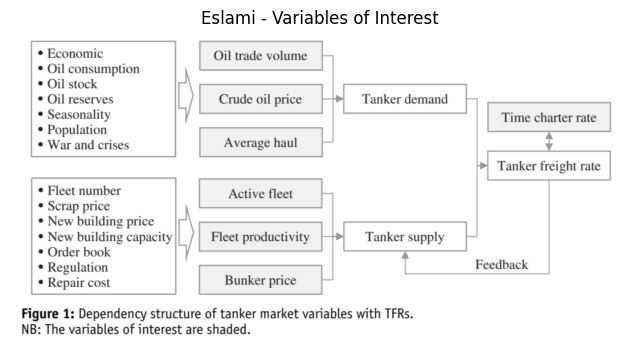

In [12]:
img = mpimg.imread('Eslami-Variables.png')  # Replace with your image path
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.title('Eslami - Variables of Interest')
plt.show()

Eslami et al. [2017], use this data from the sources listed:

| Variable                       | Source                                       |
|--------------------------------|----------------------------------------------|
| Tanker Freight Rate            | Clarkson Research Services                   |
| Brent Crude Oil Price          | U.S. Energy Information Administration (EIA) |
| Number of Operating Tankers    | Clarkson Research Services                   |
| Seaborne Oil Trade Volume      | BP Statistical Review / EIA                  |
| World Oil Supply               | International Energy Agency (IEA)            |
| Fleet Capacity (DWT)           | Clarkson Research Services                   |
| Oil Consumption                | International Energy Agency (IEA)            |

Lakkakula et al. [2025], use this data from the sources listed:

| Variable                       | Source                                       |
|--------------------------------|----------------------------------------------|
| Ocean Rate                     | Thomson Reuters                              |
| GSCPI                          | New York Federal Reserve                     |
| Baltic Exchange Dry Index      | Thomson Reuters                              |
| Oil Price (Brent)              | Thomson Reuters                              |
| Total Bulker Sales             | Clarkson’s Shipping Intelligence Research    |
| Time Charter Rates             | Clarkson’s Shipping Intelligence Research    |
| Order Book Percent Fleet       | Clarkson’s Shipping Intelligence Research    |
| US Corn Price                  | Thomson Reuters                              |
| Global Trade Index             | Clarkson’s Shipping Intelligence Research    |
| Global Trade Volume Index      | Clarkson’s Shipping Intelligence Research    |
| Global Bulk Trade Volume Index | Clarkson’s Shipping Intelligence Research    |


## 2. Data Overview

After reading the papers, most of the underlying assumptions appeared reasonable. It made a lot of sense to me that the key inputs driving freight rates include fuel prices, the value of the cargo, supply and demand dynamics, and market frictions such as port congestion. However, since I do not have access to Clarkson or Thomson Reuters data, I needed to explore alternative ways of acquiring usable data. I therefore focused on finding open-source datasets that could serve a similar purpose. I identified the following:


| Variable              | Description                                   | Frequency  | Source 
|-----------------------|-----------------------------------------------|------------|-------------
| `Gulf`                | Gulf freight price (target variable)          | Weekly     | [US Dpm of Agricultural](https://www.ams.usda.gov/services/transportation-analysis/gtr-datasets)
| `PNW`                 | Pacific Northwest freight price               | Weekly     | [US Dpm of Agricultural](https://www.ams.usda.gov/services/transportation-analysis/gtr-datasets)
| `bpi`                 | Baltic Panamax Index                          | Daily      | [See Capital Markets](https://seecapitalmarkets.com/IndexDetailed?Id=430572) 
| `brent_price`         | Brent crude oil price                         | Daily      | [US Energy Information](https://www.eia.gov/dnav/pet/hist/RBRTED.htm)
| `corn_price`          | U.S. corn price                               | Daily      | [See Capital Markets](https://seecapitalmarkets.com/Commodity?Id=72063)
| `wheat_price`         | U.S. wheat price                              | Daily      | [See Capital Markets](https://seecapitalmarkets.com/Commodity?Id=72061)
| `gscpi`               | Global Supply Chain Pressure Index            | Monthly    | [New York Federal Reserve](https://www.newyorkfed.org/research/policy/gscpi#/interactive)
| `trade_vol`           | Trade volume index                            | Monthly    | [CPB World Trade Monitor (EU Com)](https://www.cpb.nl/en/world-trade-monitor-december-2024) 
| `ships_anchored`      | Number of ships anchored (weekly avg)         | Weekly     | [U.S. Department of Transportation](https://www.bts.gov/freight-indicators#inside)
| `ships_waiting`       | Number of ships waiting (weekly avg)          | Weekly     | [U.S. Department of Transportation](https://www.bts.gov/freight-indicators#inside)
| `ship_cap`            | Container ship capacity                       | Weekly     | [U.S. Department of Transportation](https://www.bts.gov/freight-indicators#inside)

### 2.1 Description of datasets used (Gulf, PNW, BPI, Brent, etc.)

| Variable             | Description                                                                 |
|----------------------|-----------------------------------------------------------------------------|
| Gulf Freight Rates   | Weekly spot freight rates from the U.S. Gulf Coast; **target variable**.    |
| PNW Freight Rates    | Weekly freight rates from the U.S. Pacific Northwest; exogenous input.      |
| Baltic Panamax Index | Index tracking global spot rates for Panamax bulk carriers.                 |
| Brent Oil Price      | Weekly Brent crude oil price; used to proxy bunker fuel costs.              |
| Corn Price           | U.S. corn price; represents export commodity value affecting freight rates. |
| Wheat Price          | U.S. Wheat price; represents export commodity value affecting freight rates.| 
| GSCPI                | Global Supply Chain Pressure Index from NY Fed; shows logistics disruption. |
| Trade Volume Index   | Index of global trade volume; represents freight demand pressure.           |
| Ships Anchored       | Number of bulk ships anchored at ports; proxy for port congestion.          |
| Ships Waiting        | Number of bulk ships waiting at ports; proxy for port congestion.           | 
| Capacity Data        | Weekly container/tonnage supply available in the shipping market.           |



### 2.3 How data is merged, interpolated, resampled

As shown above, the data comes in different frequencies. To address this, I forward-filled the monthly data to transform it into a weekly format, and resampled the daily data using weekly means.

Unfortunately, some of the target variable data was missing, so I applied linear interpolation to fill in the missing dates. Additionally, I lost a significant portion of data due to the limited availability of my congestion proxies, which ultimately left me with 175 observations.



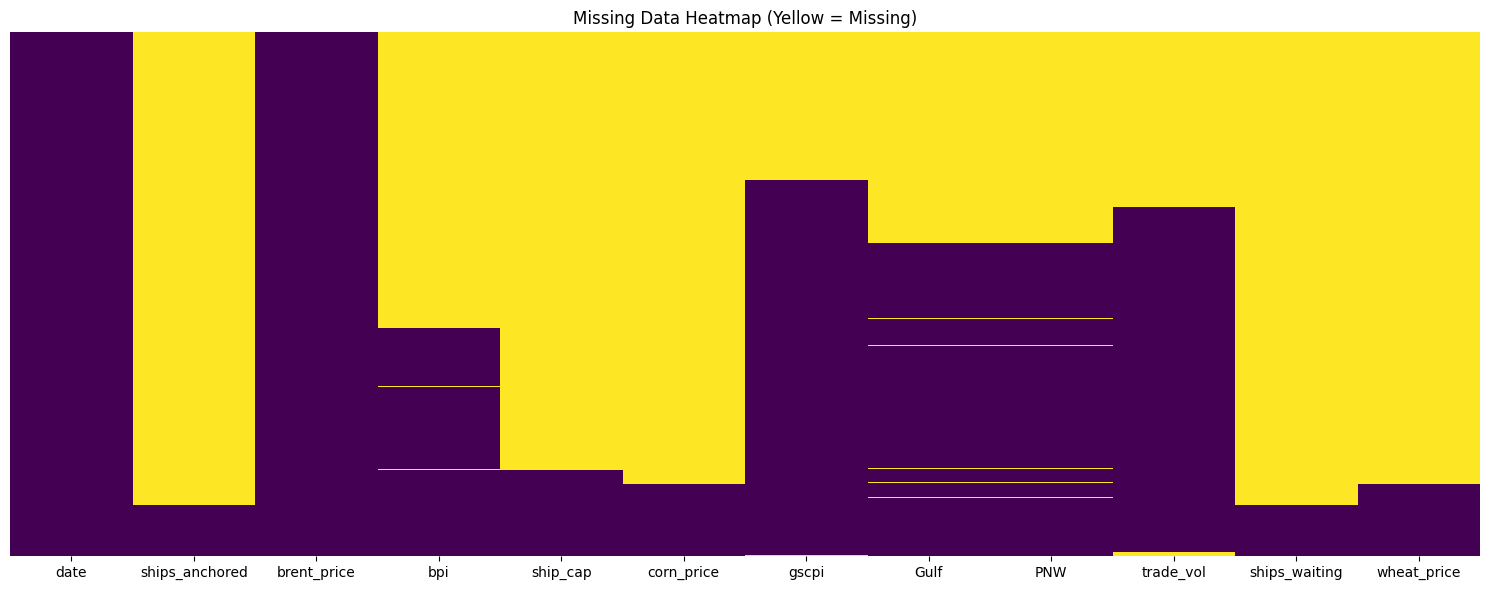

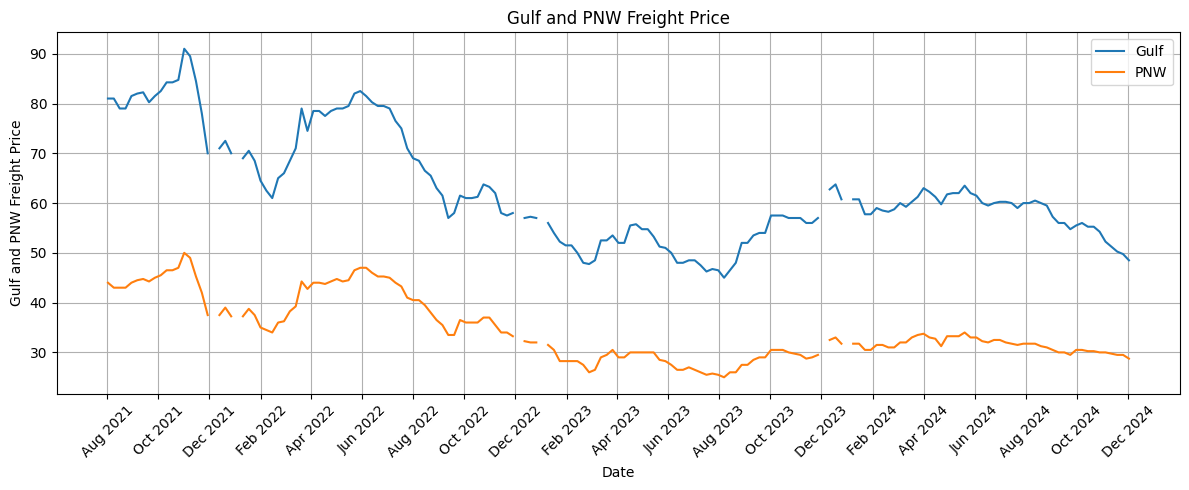

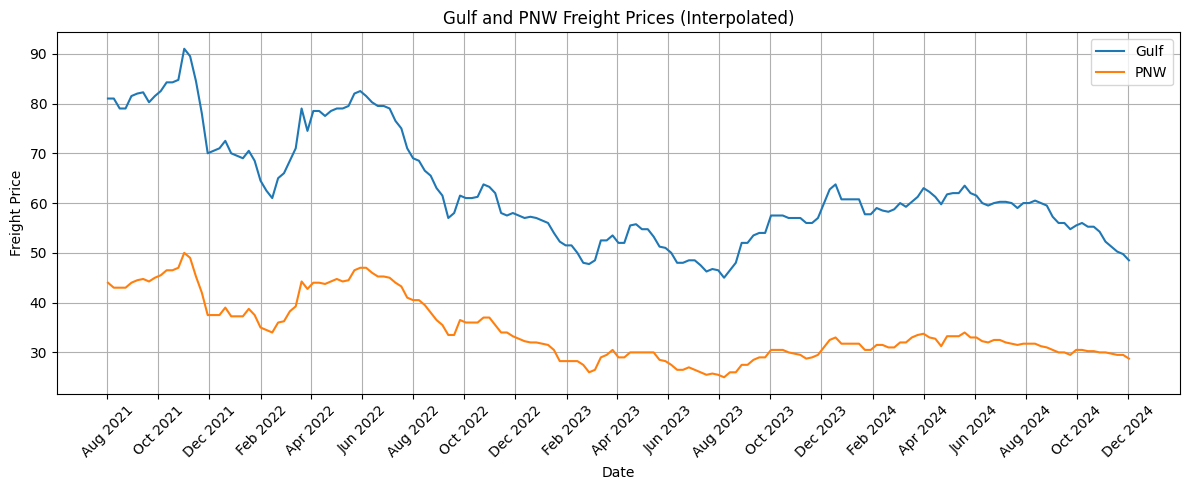

,date,ships_anchored,brent_price,bpi,ship_cap,corn_price,gscpi,Gulf,PNW,trade_vol,ships_waiting,wheat_price
1784,2021-08-02,62.0,75.5780,3361.4,1959160.0,551.271667,2.957723,81.00,44.00,99.926854,64.0,700.978333
1785,2021-08-09,59.0,71.4080,3398.0,1929809.0,552.083333,2.957723,81.00,43.00,99.926854,60.0,717.498333
1786,2021-08-16,74.0,71.1780,3538.4,1902643.0,562.853333,2.957723,79.00,43.00,99.926854,75.0,747.750000
1787,2021-08-23,62.0,67.8780,3734.4,1833497.0,546.978333,2.957723,79.00,43.00,99.926854,62.0,724.456667
1788,2021-08-30,68.0,71.5025,3879.0,1754641.0,549.978333,2.957723,81.50,44.00,99.926854,73.0,722.985000
...,...,...,...,...,...,...,...,...,...,...,...,...
1954,2024-11-04,23.0,73.2140,1199.0,2135115.0,413.400000,-0.339691,52.25,30.00,104.695613,23.0,570.200000
1955,2024-11-11,27.0,75.0920,1182.4,2056410.0,426.650000,-0.339691,51.25,29.75,104.695613,27.0,571.050000
1956,2024-11-18,24.0,73.3220,1205.8,1972044.0,427.550000,-0.339691,50.25,29.50,104.695613,24.0,543.811666
1957,2024-11-25,19.0,74.8220,1113.2,2114323.0,436.450000,-0.339691,49.75,29.50,104.695613,19.0,565.853332


In [13]:
from feature_engineering.interpolate import interpolate, before_interpolate
from feature_engineering.heat import visualize_missing_data

visualize_missing_data('../data/processed/all_data.csv')
before_interpolate('../data/processed/all_data.csv', showplot=True)
interpolate('../data/processed/all_data.csv', showplot=True)


## 3 Feature Engineering

### 3.1 Seasonal Decomposition (Additive Model)

Seasonal decomposition breaks a time series into three components:

$$
y_t = T_t + S_t + R_t
$$

Where:

-  $y_t$ is the observed time series at time $t$  
- $T_t$ is the **trend** component (long-term progression)  
- $S_t$ is the **seasonal** component (systematic calendar-related fluctuations)  
- $R_t$ is the **residual** or **random** component (irregular noise)

---

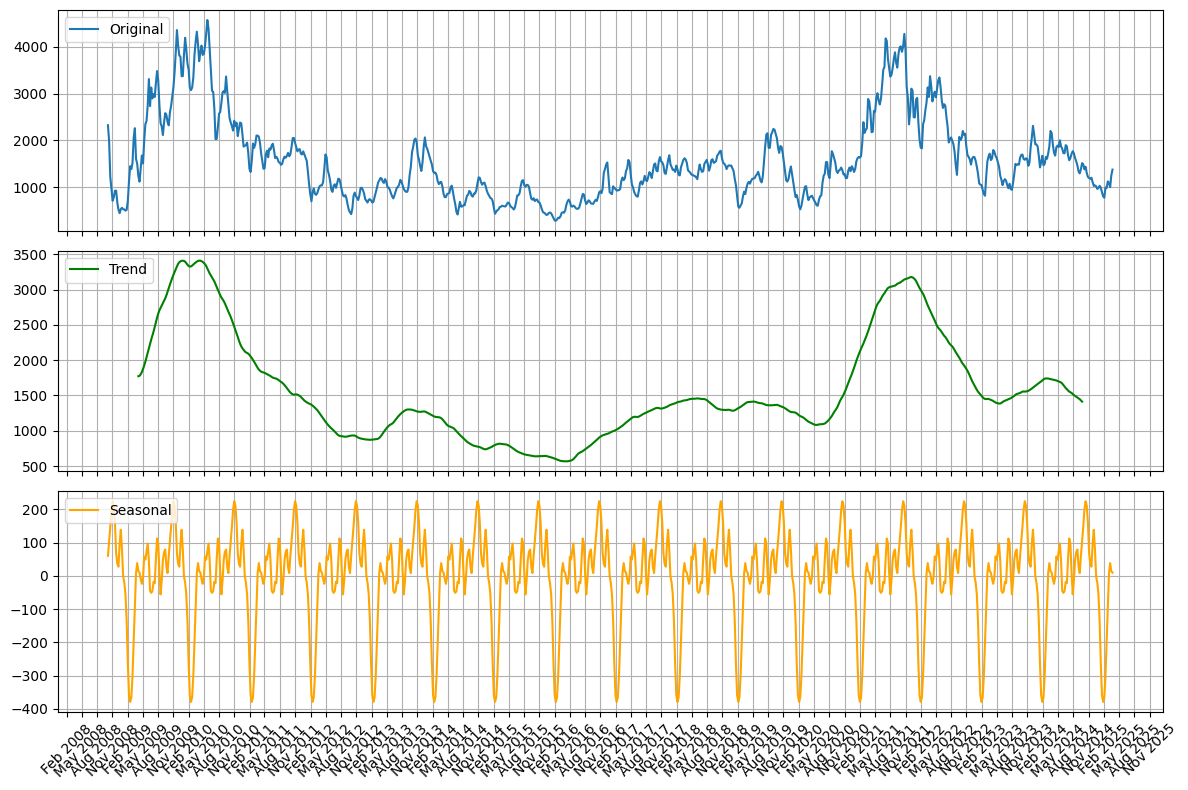

In [14]:
from feature_engineering.seasonal_decomp import compute_seasonal_features

bpi_seasonal = compute_seasonal_features(
        filepath='../data/processed/bpi.csv',
        column='bpi',
        showplot=True
    )

Above, we can see that the Baltic Panamax Index has been affected by major exogenous shocks to the global economy—such as the 2008 financial crisis, the COVID-19 pandemic in 2019, and the outbreak of the war in Ukraine in 2022.

Below, we observe the more volatile Brent spot price. Since this time series spans a longer period, we can trace its fluctuations all the way back to events like 9/11, the Iraq War, the 2008 financial crisis, the U.S. shale boom, the COVID-19 pandemic, and the Ukraine war. Much of the short-term volatility is driven by OPEC decisions, which fall outside the scope of my expertise.

Nonetheless, I extract both trend and seasonality components from the data to use as features in the model.



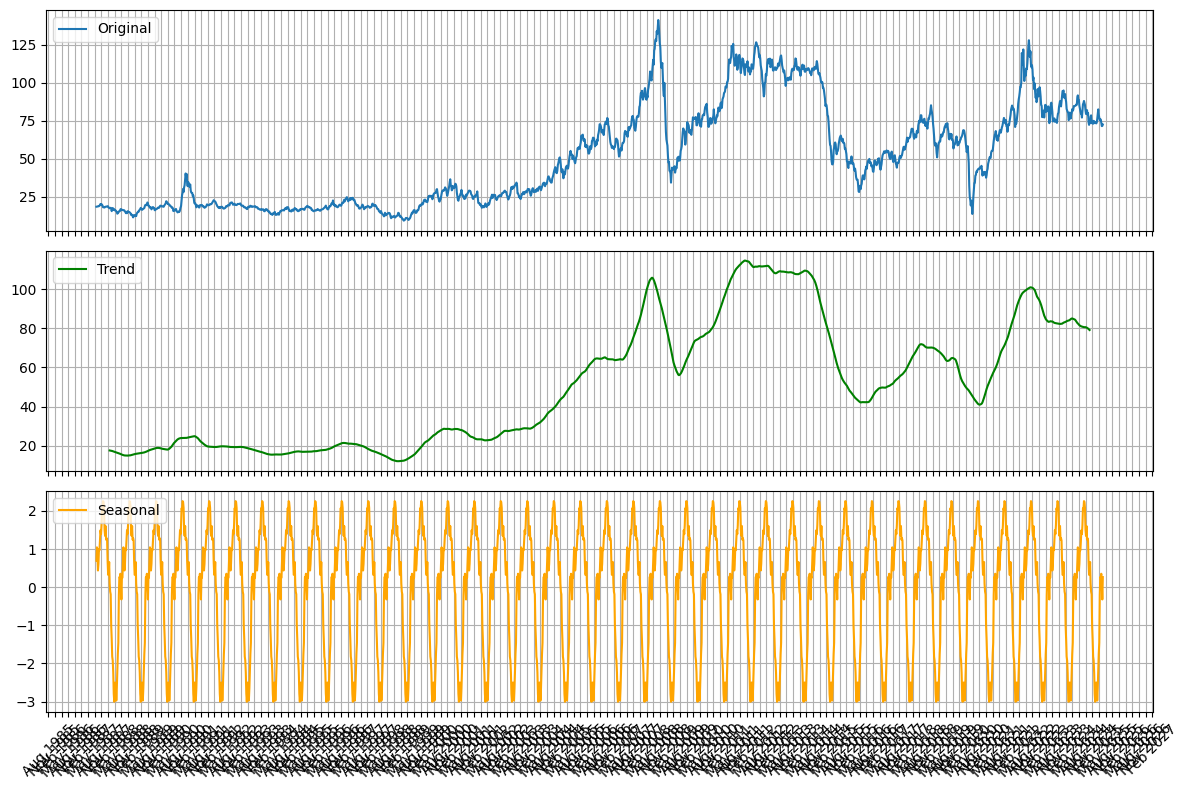

In [15]:
brent_seasonal = compute_seasonal_features(
        filepath='../data/processed/brent.csv',
        column='brent_price',
        showplot=True
    )


### 3.2 BPI Volatility

The final feature I created is BPI_volatility, intended as a proxy for market uncertainty. Once again, we observe heightened market uncertainty around major global events such as the 2008 financial crisis, the COVID-19 pandemic in 2019, and the Ukraine war in 2022.

The fully processed dataset can be viewed below.

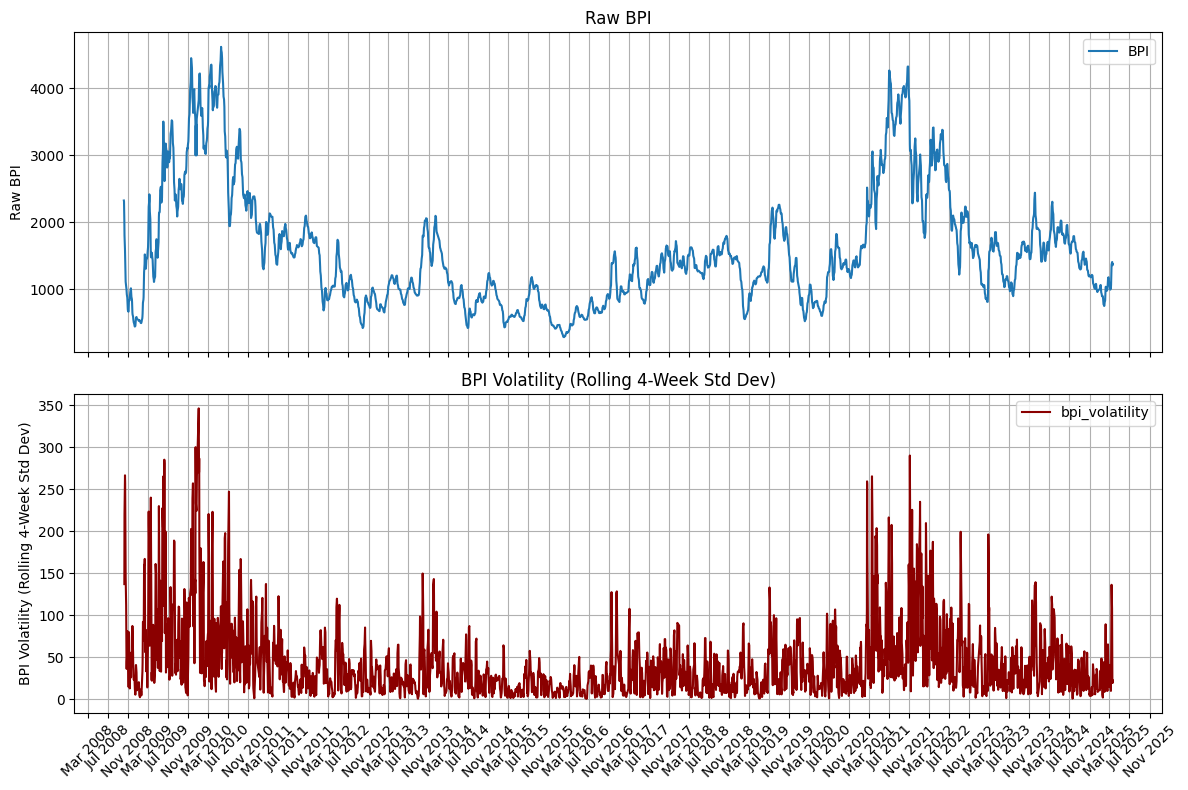

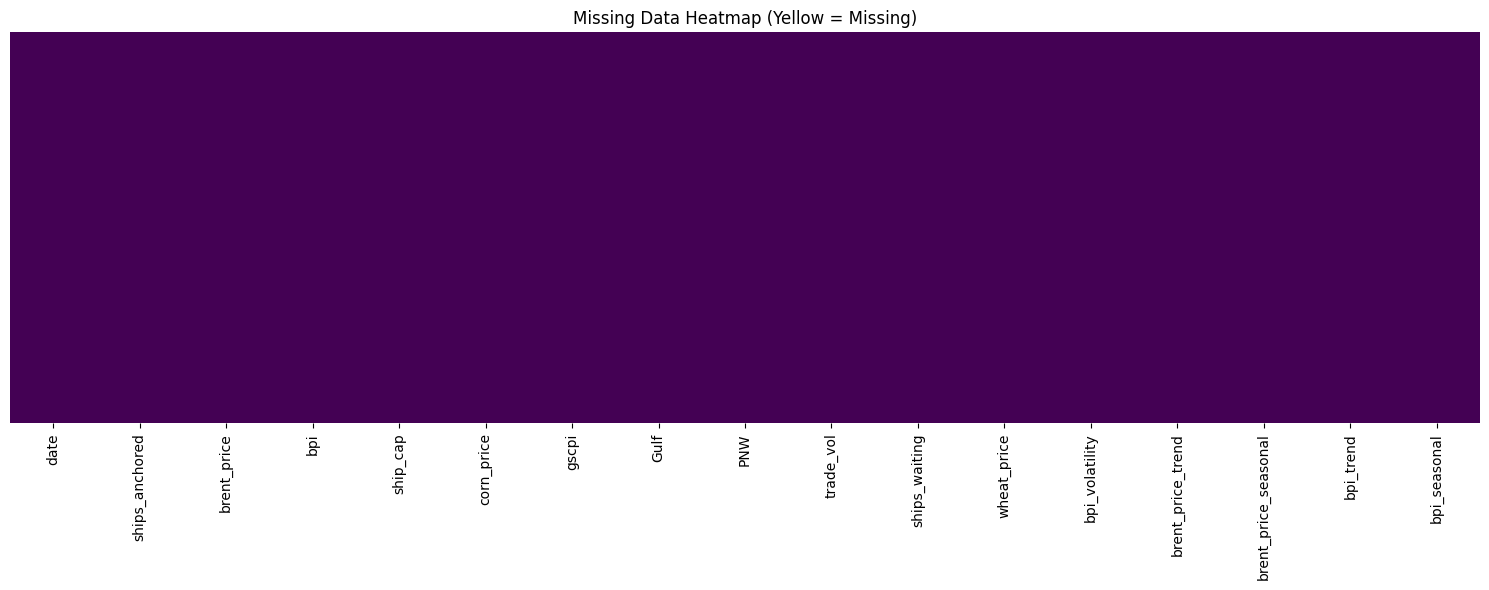

In [16]:
from feature_engineering.generate_volatility import compute_bpi_volatility

compute_bpi_volatility('../data/processed/bpi.csv', showplots=True)
visualize_missing_data('../data/processed/processed.csv')

Here is a full review of all Variable within the Processed dataset: 

| Variable              | Description                                   |
|-----------------------|-----------------------------------------------|
| `date`                | Weekly date (usually Monday)                  |
| `Gulf`                | Gulf freight price (target variable)          |
| `PNW`                 | Pacific Northwest freight price               |
| `bpi`                 | Baltic Panamax Index                          |
| `bpi_trend`           | Trend component of BPI                        |
| `brent_price`         | Brent crude oil price                         |
| `brent_price_trend`   | Trend of Brent oil price                      |
| `corn_price`          | U.S. corn price                               |
| `wheat_price`         | U.S. wheat price                              |
| `gscpi`               | Global Supply Chain Pressure Index            |
| `bpi_seasonal`        | Seasonal component of BPI                     |
| `brent_price_seasonal`| Seasonal component of Brent price             |
| `bpi_volatility`      | 4-week rolling standard deviation of BPI      |
| `trade_vol`           | Trade volume index                            |
| `ships_anchored`      | Number of ships anchored (weekly avg)         |
| `ships_waiting`       | Number of ships waiting (weekly avg)          |
| `ship_cap`            | Container ship capacity                       |

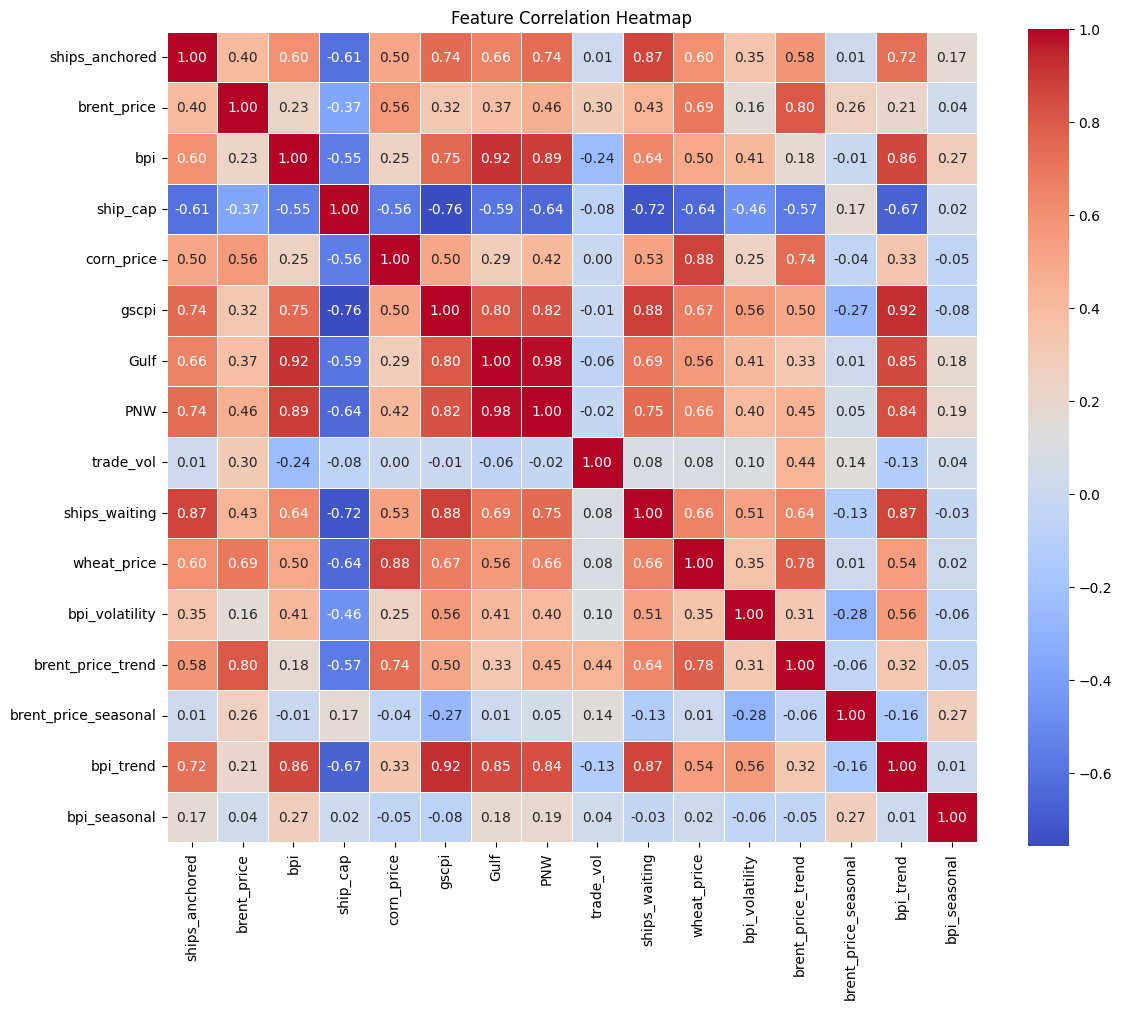

[('PNW', 'Gulf', 0.9816564907743088),
 ('bpi_trend', 'gscpi', 0.9204912565793093),
 ('Gulf', 'bpi', 0.9155909351532581),
 ('PNW', 'bpi', 0.8865909452754251),
 ('ships_waiting', 'gscpi', 0.8823316281943757),
 ('wheat_price', 'corn_price', 0.8762442928345138),
 ('bpi_trend', 'ships_waiting', 0.8666512778141378),
 ('ships_waiting', 'ships_anchored', 0.8650896505803322),
 ('bpi_trend', 'bpi', 0.8586649344834348),
 ('bpi_trend', 'Gulf', 0.8519148113794496),
 ('bpi_trend', 'PNW', 0.8354132242766172),
 ('PNW', 'gscpi', 0.8217304547597353),
 ('Gulf', 'gscpi', 0.8048690604231017),
 ('brent_price_trend', 'brent_price', 0.8016308544650653)]

In [17]:
import importlib
import modeling.check_multicollinearity  # replace with your module name
importlib.reload(modeling.check_multicollinearity)


from modeling.check_multicollinearity import check_multicollinearity

check_multicollinearity('../data/processed/processed.csv',showplot=True)


## **Baseline Model**
### 4.1 Dumbest model imaginable — the constant mean predictor 
    
So I generate the baseline model, as it: 
    Mean model: 
    $$ŷ = avg(y_{(train)})$$


### Evaluation Metrics: MAE and $ R^2 $

---

**Mean Absolute Error (MAE)**  
MAE measures the average magnitude of the errors between predicted and actual values, without considering direction.

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^n |y_i - \hat{y}_i|
$$

- Lower MAE indicates better predictive accuracy.
- Interpretable in the same units as the target variable.

---

**$ R^2 $ Score (Coefficient of Determination)**  
$ R^2 $ represents the proportion of variance in the target variable that is predictable from the input features.

$$
R^2 = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2}
$$

- $ R^2 = 1 $: perfect prediction  
- $ R^2 = 0 $: model performs no better than the mean  
- $ R^2 < 0 $: model performs worse than the mean

---

These metrics are used to evaluate and compare the performance of all models in this project.


# 5. **Machine Learning Models**
### 5.1 Short Description of the Models

---

**ARIMAX (Lagged Exogenous)**  
A classical time series model that extends ARIMA to include external regressors. We use lagged values of external features $ x_t $ to predict future freight rates $ y_{t+1} $.

Mathematically:

$$
y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \dots + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \beta_1 x_{t-1}^{(1)} + \dots + \beta_k x_{t-1}^{(k)} + \varepsilon_t
$$

Where:  
- $ y_t $: target variable (e.g., Gulf rate)  
- $ x_{t-1}^{(k)} $: lagged exogenous variable $ k $  
- $ \phi $: AR coefficients  
- $ \theta $: MA coefficients  
- $ \beta $: coefficients for exogenous regressors  
- $ \varepsilon_t $: white noise error

---

**Prophet (Univariate & Multivariate)**  
A decomposable additive model developed by Facebook. It models time series as a sum of trend, seasonality, and holiday components.

Prophet’s additive model:

$$
y(t) = g(t) + s(t) + h(t) + \varepsilon_t
$$

Where:  
- $ g(t) $: trend function  
- $ s(t) $: seasonal component  
- $ h(t) $: holiday effects (not used in our case)  
- $ \varepsilon_t $: error term  

In the multivariate case, regressors $ x_t $ are included linearly:

$$
y(t) = g(t) + s(t) + \sum_{i} \beta_i x_t^{(i)} + \varepsilon_t
$$

---

**Lasso & Ridge Regression**  
Linear models with regularization to prevent overfitting. Ridge shrinks coefficients; Lasso can shrink some to exactly zero.

- **Ridge (L2 penalty)**:

$$
\min_{\beta} \left\{ \sum_{i=1}^n (y_i - X_i \beta)^2 + \lambda \sum_{j=1}^p \beta_j^2 \right\}
$$

- **Lasso (L1 penalty)**:

$$
\min_{\beta} \left\{ \sum_{i=1}^n (y_i - X_i \beta)^2 + \lambda \sum_{j=1}^p |\beta_j| \right\}
$$

---

**Support Vector Regression (SVR)**  
A non-linear regression model that fits a function within an epsilon-insensitive tube and penalizes deviations outside it.

Objective:

$$
\min_{\mathbf{w}, b} \frac{1}{2} ||\mathbf{w}||^2 + C \sum_{i=1}^n (\xi_i + \xi_i^*)
$$

Subject to:

$$
\begin{align}
y_i - \mathbf{w}^\top x_i - b &\leq \varepsilon + \xi_i \\
\mathbf{w}^\top x_i + b - y_i &\leq \varepsilon + \xi_i^* \\
\xi_i, \xi_i^* &\geq 0
\end{align}
$$

---

**XGBoost (Extreme Gradient Boosting)**  
An ensemble method using sequential decision trees trained to minimize prediction errors.

The model predicts as a sum of decision trees:

$$
\hat{y}_i = \sum_{k=1}^K f_k(x_i), \quad f_k \in \mathcal{F}
$$

Where:  
- $ f_k $: individual regression trees  
- $ \mathcal{F} $: space of all regression trees  
- Training minimizes:

$$
\mathcal{L} = \sum_{i} \ell(y_i, \hat{y}_i) + \sum_k \Omega(f_k)
$$

with regularization $ \Omega(f_k) $ to control complexity.

---



In [18]:
import importlib
import modeling.linear_regression.lasso
importlib.reload(modeling.linear_regression.lasso)


from modeling.linear_regression.lasso import run_lasso_regression

run_lasso_regression('../data/processed/processed.csv')

Lasso Test MAE: 1.22
Average Actual Gulf: 59.95
Selected Alpha: 0.0532


(LassoCV(cv=5, random_state=42),
                  Feature  Coefficient
 6                    PNW     6.374508
 2                    bpi     5.861189
 1            brent_price     0.960137
 4             corn_price    -0.605112
 12  brent_price_seasonal    -0.308948
 0         ships_anchored    -0.298084
 14          bpi_seasonal    -0.240364
 8          ships_waiting    -0.101632
 10        bpi_volatility     0.091315
 5                  gscpi     0.010817
 3               ship_cap     0.000000
 7              trade_vol     0.000000
 9            wheat_price    -0.000000
 11     brent_price_trend    -0.000000
 13             bpi_trend     0.000000)

'bpi', 'PNW', 'brent_price', 'corn_price', 'ships_anchored'

# 6. **Model Comparison**
## 6.1 Table of all model MAEs and R²


In [19]:
from IPython.display import Markdown

with open('../reports/models/model_results.txt', 'r') as f:
    md_text = f.read()

display(Markdown(f"```\n{md_text}\n```"))


```

--- Lasso Regression with Lags (2025-04-07 11:12) ---
Lasso MAE: 0.91
Lasso R² Score: 0.694

--- Auto ARIMA (2025-04-07 11:12) ---
Auto ARIMA MAE: 1.47
Auto ARIMA R²: -0.065

--- ARIMAX (2025-04-07 11:12) ---
ARIMAX MAE: 0.50
ARIMAX R²: 0.903

--- ARIMAX Lagged (2025-04-07 11:12) ---
ARIMAX Lagged MAE: 0.84
ARIMAX Lagged R²: 0.710

--- Lasso Regression (2025-04-07 11:12) ---
Lasso MAE: 1.22
Lasso R² Score: 0.436

--- Lasso Regression with Lags (2025-04-07 11:12) ---
Lasso MAE: 0.91
Lasso R² Score: 0.694

--- Ridge Regression (2025-04-07 11:12) ---
Ridge MAE: 1.25
Ridge R² Score: 0.400

--- Uni Prophet Regression (2025-04-07 11:12) ---
Uni Prophet MAE: 2.75
Uni Prophet R² Score: -2.879

--- Multi Prophet (2025-04-07 11:12) ---
Multi Prophet MAE: 4.25
Multi Prophet R² Score: -4.332

--- Support Vector Regression (2025-04-07 11:12) ---
SVM MAE: 1.43
SVM R² Score: -0.051

--- XGBoost Regression (2025-04-07 11:12) ---
XGBoost MAE: 0.97
XGBoost R² Score: 0.590

```

 ## 6.2 Prediction plot (Actual vs. Predicted)

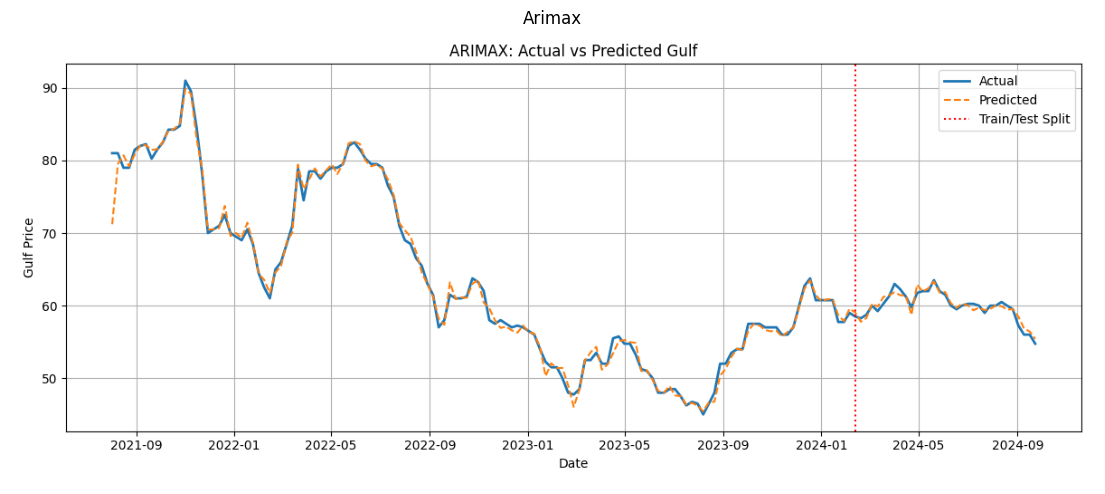

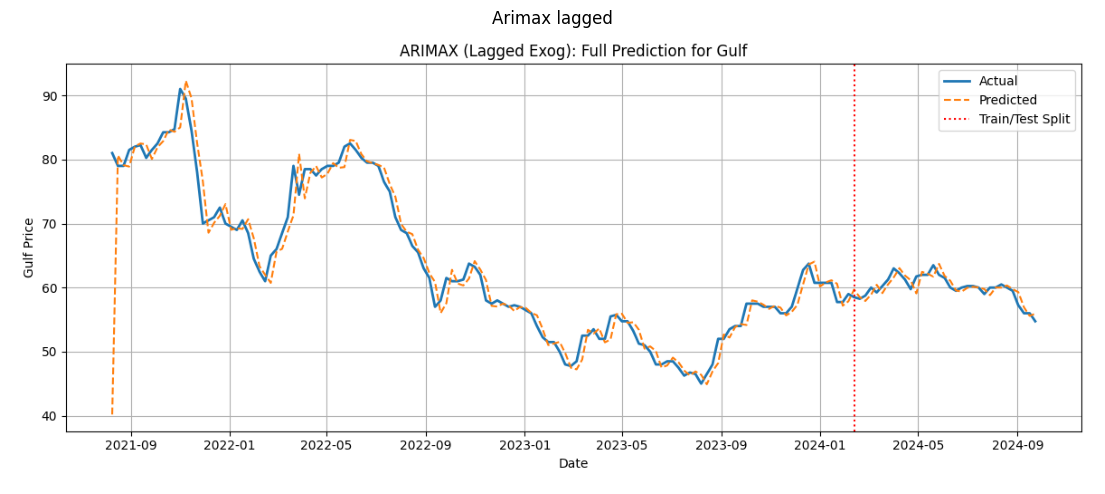

In [20]:
img = mpimg.imread('../reports/models/Gulf_arimax_prediction_plot.png')  # Replace with your image path
plt.figure(figsize=(14, 10))
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.title('Arimax')
plt.show()

img = mpimg.imread('../reports/models/Gulf_arimax_lagged_prediction_plot.png')  # Replace with your image path
plt.figure(figsize=(14, 10))
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.title('Arimax lagged')
plt.show()
